In [0]:
# Initialisation

In [2]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, CuDNNGRU, GRU
from keras.callbacks import EarlyStopping
from keras.datasets import imdb

Using TensorFlow backend.


In [0]:
# Constants and helpers

In [0]:
num_words = 3000

In [0]:
# Load and massage data

In [6]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words, skip_top=5)  # downloads ~20mb of data

print(len(x_train), x_train[0], y_train[0])

25000 [2, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 2, 66, 2, 2, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 2, 172, 112, 167, 2, 336, 385, 39, 2, 172, 2, 1111, 17, 546, 38, 13, 447, 2, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 2, 1920, 2, 469, 2, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 2, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 2, 2223, 2, 16, 480, 66, 2, 33, 2, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 2, 107, 117, 2, 15, 256, 2, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 2, 2, 1029, 13, 104, 88, 2, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 2, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 2, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32] 1


In [7]:
# ensure all reviews are padded to the longest review
max_review_length = max(len(review) for review in x_train + x_test)
x_test = pad_sequences(x_test, maxlen=max_review_length)
x_train = pad_sequences(x_train, maxlen=max_review_length)

print(max_review_length)

2697


In [0]:
# Model definition and training

In [0]:
model = Sequential()

model.add(Embedding(num_words, 128))  # Layer, coverts each token to vector in a 32-dim space
model.add(CuDNNGRU(128))  # GRU layer with specific CUDA optimization, does not support dropout
# model.add(GRU(32))  # no cude on my laptop eh
model.add(Dense(16, activation='tanh'))  # Just slap another layer in
model.add(Dense(1, activation='sigmoid'))  # Fully connected positive/negative layer

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [10]:
early_stop_callback = EarlyStopping(
    monitor='val_acc',
    patience=5,
    mode='max'
)

train_history = model.fit(  # ~1.5 min per epoch on colab with gpu backend
    x_train,
    y_train,
    batch_size=128,  # aggressive batch size to speed up training a bit
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[early_stop_callback,]
)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 125s 5ms/step - loss: 0.4852 - acc: 0.7579 - val_loss: 0.3966 - val_acc: 0.8194
Epoch 2/20
25000/25000 [==============================] - 123s 5ms/step - loss: 0.3029 - acc: 0.8773 - val_loss: 0.2958 - val_acc: 0.8778
Epoch 3/20
25000/25000 [==============================] - 122s 5ms/step - loss: 0.2414 - acc: 0.9047 - val_loss: 0.2977 - val_acc: 0.8827
Epoch 4/20
25000/25000 [==============================] - 122s 5ms/step - loss: 0.2002 - acc: 0.9244 - val_loss: 0.2893 - val_acc: 0.8830
Epoch 5/20
25000/25000 [==============================] - 122s 5ms/step - loss: 0.1659 - acc: 0.9381 - val_loss: 0.3070 - val_acc: 0.8776
Epoch 6/20
25000/25000 [==============================] - 122s 5ms/step - loss: 0.1375 - acc: 0.9510 - val_loss: 0.3292 - val_acc: 0.8760
Epoch 7/20
25000/25000 [==============================] - 122s 5ms/step - loss: 0.1105 - acc: 0.9628 - val_loss: 0.3788 - 

In [0]:
# Scoring and evaluation

In [12]:
score, accuracy = model.evaluate(
    x_test,
    y_test,
    batch_size=1000
)
print('test score:', score, ' test accuracy:', accuracy)

25000/25000 [==============================] - 16s 635us/step
test score: 0.44414350628852844  test accuracy: 0.8632400012016297


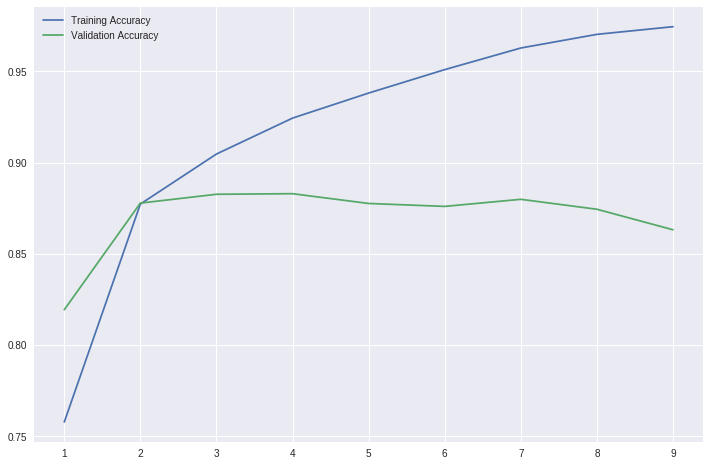

In [13]:
from matplotlib import pyplot as plt

epoch_list = list(range(1, len(train_history.history['acc']) + 1))  # values
plt.figure(figsize=(12, 8))
plt.plot(epoch_list, train_history.history['acc'], epoch_list, train_history.history['val_acc'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))

plt.show()  # overfitting yay.

In [0]:
# Trial with some dropout layers

In [0]:
from keras.layers import Dropout

drop_model = Sequential()

drop_model.add(Embedding(num_words, 128))
drop_model.add(CuDNNGRU(128))
drop_model.add(Dropout(0.25))
drop_model.add(Dense(64, activation='sigmoid'))
drop_model.add(Dropout(0.25))
drop_model.add(Dense(1, activation='sigmoid'))

drop_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [18]:
early_stop_callback = EarlyStopping(
    monitor='val_acc',
    patience=6,
    mode='max'
)

drop_train_history = drop_model.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=30,
    validation_data=(x_test, y_test),
    callbacks=[early_stop_callback,]
)

Train on 25000 samples, validate on 25000 samples
Epoch 1/30
25000/25000 [==============================] - 121s 5ms/step - loss: 0.5664 - acc: 0.6866 - val_loss: 0.5214 - val_acc: 0.7419
Epoch 2/30
25000/25000 [==============================] - 120s 5ms/step - loss: 0.4159 - acc: 0.8193 - val_loss: 0.7890 - val_acc: 0.7781
Epoch 3/30
25000/25000 [==============================] - 121s 5ms/step - loss: 0.3609 - acc: 0.8579 - val_loss: 0.4369 - val_acc: 0.8226
Epoch 4/30
25000/25000 [==============================] - 121s 5ms/step - loss: 0.2793 - acc: 0.8938 - val_loss: 0.3397 - val_acc: 0.8559
Epoch 5/30
25000/25000 [==============================] - 121s 5ms/step - loss: 0.2401 - acc: 0.9122 - val_loss: 0.2878 - val_acc: 0.8836
Epoch 6/30
25000/25000 [==============================] - 121s 5ms/step - loss: 0.2095 - acc: 0.9263 - val_loss: 0.2846 - val_acc: 0.8863
Epoch 7/30
25000/25000 [==============================] - 120s 5ms/step - loss: 0.1875 - acc: 0.9344 - val_loss: 0.3202 - 

In [12]:
score, accuracy = drop_model.evaluate(
    x_test,
    y_test,
    batch_size=1000
)
print('test score:', score, ' test accuracy:', accuracy)

25000/25000 [==============================] - 15s 613us/step
test score: 0.3315722143650055  test accuracy: 0.8741999959945679


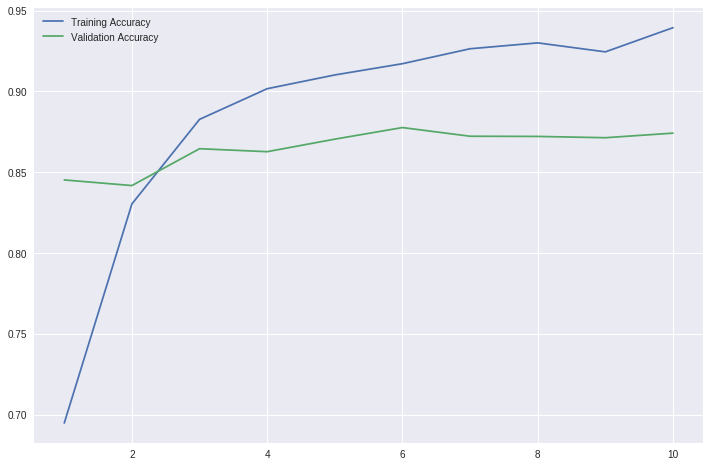

In [14]:
from matplotlib import pyplot as plt

epoch_list = list(range(1, len(drop_train_history.history['acc']) + 1))  # values
plt.figure(figsize=(12, 8))
plt.plot(epoch_list, drop_train_history.history['acc'], epoch_list, drop_train_history.history['val_acc'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))

plt.show()